In [12]:
### RUN THIS CELL ###
# Load software packages #
import nbimporter
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import math
import pandas as pd

from scipy.linalg import eigh, cholesky
from scipy.stats import norm
from pylab import plot, show, axis, subplot, xlabel, ylabel, grid


import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
### RUN THIS CELL ###

In [13]:
# RUN THIS CELL #
# getModelStats - takes a model and has it predict on X. Then accuracy, precision, and recall on X is printed.
# @params 
#. model - fitted model 
#  X - df of individuals with selectedFeatures, 
#  y - labels of X individuals.
def getModelStats(model, X, y):
    y_pred = model.predict(X)
    vals = {}
    for x in range(len(y_pred)):
        if y_pred[x] not in vals:
            vals.update({y_pred[x]: 1})
        else: 
            vals[y_pred[x]] += 1
    print(vals)
    print("The accuracy of our model on the data is: ", accuracy_score(y_pred, y))
    print("The precision of our model on the data is: ", precision_score(y_pred, y, average='macro'))
    print("The recall of our model on the data is: ", recall_score(y_pred, y, average='macro'))

# classificationSelection - selects candidates w. "Labels" field value of acceptValue
# @param
#.   - candidates is a dataframe of candidates
#.   - labels is an array of the predictions for the candidates
#.   - acceptValue is the label value we are seeking for candidates to be selected
# @return
#.   - candidatesSelected is a dataframe of selected candidates.
def classificationSelection(candidates, labels, acceptValue):
    df = candidates.copy()
    df["Labels"] = labels
    candidatesSelected = df[df["Labels"].isin([acceptValue])]
    return candidatesSelected

# getOnehottedDataset - takes a dataframe, a set of features, and prefix names for those features, and one-hots those features.
# Note: ENSURE that the features passed in are discrete/not continuous. 
# @params: 
#    - dataset is a dataframe of individuals you seek to onehot the features of
#    - features is an array of features in the dataset you wish to one-hot
#    - prefixes is an array of names that will be the prefixes of the new columns produced via the one-hot function
# @return: 
#    - returns the dataset with the features, one-hotted.        
def getOnehottedDataset(dataset, features, prefixes):
    onehotted_data = dataset.copy()
    onehotted_data = pd.get_dummies(onehotted_data, columns=features, prefix=prefixes)
    return onehotted_data

# graphSelectionRates - outputs a bar graph of the selection rates for each protectedClass, depending on the protected
# class you pass in (race or gender). 
# @params: 
#    - selected is a dataframe of all of the candidates that were chosen by the algorithm
#    - candidates is a dataframe containing all candidates
#    - protectedClass is a flag passed in as either "race" or "gender" depending on what the selection rates you'd like
# @return: 
#    - prints selection rates and a bar graph.
def graphSelectionRates(selected, candidates, protectedClass):
    selected_candidates = selected.copy()
    candidates_all = candidates.copy()
    raceIndxs = {"Caucasian": 0, "African-American": 1, "Asian": 2, "Hispanic": 3, "Other": 4 }
    sexIndxs = {"Male":0, "Female":1}
    
    if protectedClass == "race":
        features = [col for col in selected_candidates if col.startswith("race_")]
        race_selected = selected_candidates[features].idxmax(axis=1).str.replace('race_', '')
        race_all = candidates_all[features].idxmax(axis=1).str.replace('race_', '')
        
        candidates_all["Race"] = race_all
        selected_candidates["Race"] = race_selected

        numCandidates = candidates_all["Race"].value_counts()
        numQualified = selected_candidates["Race"].value_counts()

        selectionRate1 = numQualified["Caucasian"] / numCandidates["Caucasian"]
        selectionRate2 = numQualified["Asian"] / numCandidates["Asian"]
        selectionRate3 = numQualified["African-American"] / numCandidates["African-American"]
        selectionRate4 = numQualified["Hispanic"] / numCandidates["Hispanic"]
        selectionRate5 = numQualified["Other"] / numCandidates["Other"]
        
        print("The selection rate for " + "Caucasian" + "s: ",selectionRate1)
        print("The selection rate for " + "Asian" + "s: ", selectionRate2)
        print("The selection rate for " + "African-American" + "s: ",selectionRate3)
        print("The selection rate for " + "Hispanic" + "s: ",selectionRate4)
        print("The selection rate for " + "Other Race" + "s: ", selectionRate5)
        
        y_pos = np.arange(5)
        performance = [selectionRate1, selectionRate2, selectionRate3, selectionRate4, selectionRate5]
        plt.bar(y_pos, performance, align='center', alpha=0.5)
        plt.xticks(y_pos, ("Caucasian", "Asian", "African-American", "Hispanic", "Other"))
        plt.ylabel('Selection Rate')
        plt.title('Selection Rate Comparisons by Race')
        plt.show()
    elif protectedClass == "gender":
        
        features = [col for col in selected_candidates if col.startswith("gender_")]
        gender_selected = selected_candidates[features].idxmax(axis=1).str.replace('gender_', '')
        gender_all = candidates_all[features].idxmax(axis=1).str.replace('gender_', '')

        candidates_all["Gender"] = gender_all
        selected_candidates["Gender"] = gender_selected
        
        numCandidates = candidates_all["Gender"].value_counts()
        numQualified = selected_candidates["Gender"].value_counts()
        
        print(numCandidates)
        print(numQualified) 
        
        maleSelectionRate = numQualified["male"] / numCandidates["male"]
        femaleSelectionRate = numQualified["female"] / numCandidates["female"]
        print("The selection rate for " + "Male" + "s: ", maleSelectionRate)
        print("The selection rate for " + "Female" + "s: ", femaleSelectionRate)
        y_pos = np.arange(2)
        performance = [maleSelectionRate, femaleSelectionRate]
        plt.bar(y_pos, performance, align='center', alpha=0.5)
        plt.xticks(y_pos, ("Male", "Female"))
        plt.ylabel('Selection Rate')
        plt.title('Selection Rate Comparisons by Sex')
        plt.show()
    else:
        print("Try another protected type - gender or race")

# selectPersonsInClass - Takes the dataset and returns all members in the dataset whose protectedClass is of the value
# For example, if protectedClass=race and value="African-American", returns all African-Americans in the dataset.
# @params
#.  - data - is the df of individuals we want to select individuals from
#.  - protectedClass - is the protected class, race, gender, etc. we want to select from
#.  - value - value is the group within that protected Class we want to select out (e.g female, or hispanic)
#. @returns
#.  - df the individuals in the selected group in the protected class of the data.
def selectPersonsInClass(data, protectedClass, value):
    df = data.loc[(data[protectedClass] == value)]
    print("Num of rows of ppl who are %s:"% (value ,), len(df))
    return df

# RUN THIS CELL #    

# Milestone 2
## Exercise 3: Deploying a Model. 

Ok in this final exercise your team will be tasked with choosing, tweaking, and/or building a model to deploy on our prospective job candidates! You're then going to be asked to settle on your approach and discuss your process and addressal of challenges in a memo. Exciting & precarious stuff!

We've gone and implemented a barebones multi-class Logistic Regression Model. If that sounds scary don't worry, its really not that complicated and besides the point, its just meant to be a placeholder as your team walks through the exercise and decides on your own approach.

In [14]:
# RUN THIS CELL #  
# Loading the dataset
employees = pd.read_csv("../Employees_M2/employees_milestone2.csv")
candidates = pd.read_csv("../Candidates_M2/candidates_milestone2.csv")

In [15]:
# RUN THIS CELL (0 Lines) #
# One-hotting the dataset for use #
features = ["Race", "Gender", "Birth Origin", "Criminal Record", "Sports",
           "Arrest Record", "LinkedIn Score", "Responsible Social Media Use", "Undergraduate Degree", "Employee Referral"]
prefixes = ["race", "gender", "origin", "criminal", "arrest", "sports", "linkedin", 
           "socmedia", "degree", "referral"]
employees_race = employees["Race"]
candidates_race = candidates["Race"]
employees_processed = getOnehottedDataset(employees, features, prefixes)
employees_processed["Race"] = employees_race
candidates_processed = getOnehottedDataset(candidates, features, prefixes)
candidates_processed["Race"] = candidates_race
employees_processed.info()
# RUN THIS CELL #

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Names                       10000 non-null  object 
 1   Age                         10000 non-null  float64
 2   Zip                         10000 non-null  int64  
 3   Education                   10000 non-null  int64  
 4   GPA                         10000 non-null  float64
 5   Educational Prestige        10000 non-null  float64
 6   Years of Experience         10000 non-null  float64
 7   Soft Skills                 10000 non-null  float64
 8   Manager's Assessment Score  10000 non-null  float64
 9   Military Tenure             10000 non-null  float64
 10  Avg Commute Time            10000 non-null  float64
 11  Job Tenure                  10000 non-null  float64
 12  Cultural Fit                10000 non-null  float64
 13  Leadership Capability       1000

### Task 1: Data Engineering

In this section you'll decide on which features to include, segments of data to include/exclude, a performance metric, and method of label generation for your employees. It's not necessary to think of these needing to be done in a particular order.

- Choose features.
- Include/Exclude Data - Change the distribution of the dataset for different training results.
- Formulating a performance metric.
- Formulate a label generation method.

#### Selecting Features: Ok, you're going to want to select some features based on what's available to you now that we've one-hotted the dataset. Some key considerations...
- What features are the most predictive of performance
- What features may be useful for some subgroups but not others. 
- What features may have unequal distributions between different group.

In [16]:
# Choose features and metric to use for your model (1 Line)
selectedFeatures = [
    "GPA", "Educational Prestige", "Technical Aptitude"
]

#### Choose a Metric:  Some key considerations...
- Is the metric's value distribution equal among the different groups? 
- Could some "linear combination" of the metrics be more predictive or meaningful to you?
- Should your metric include non-performance related features like GPA, or cultural fit?

In [17]:
# Use a pre-existing or make your own metric! (1 Line)
metric = "Avg Deals Closed"

#### Pick a Label Generation Method: Here we've chosen a metric to use as part of our model training. If you're planning on using a regression technique then you can skip this method as you'll be directly training to predict the metric score. However if you're using a classification algorithm then you need to bucket the employees in some way. 

Some considerations...
- Does my label generation method make me vulnerable to false positives? false negatives?
- How will my resulting labels be used to make the actual decision when it comes to candidates. 

In [18]:
# Insert Label Generation Method (3-5 Lines) #

# assignLabelsByPercentile - is a function labelling the dataset by taking the metric scores of the individuals 
# in the dataset and splitting them into ranked percentile ranges (top Xth percent, next Xth percent, etc.)
# @params - 
#.  dataset is a dataframe of individuals
#.  metric - is the feature value we want to rank then divide individuals by
# @returns - 
#.  dataset with labels. 
def assignLabelsByPercentile(employees, metric, percentile):
    employees_labelled = employees.copy()
    employees_labelled = employees_labelled.sort_values([metric], ascending=False)
    nths = math.floor(len(employees_labelled) / percentile)
    num = percentile - 1
    labels = []
    for x in range(percentile):
        for y in range(nths):
            labels.append(num)
        num -= 1
    while (len(labels) != len(employees)):
        labels.append(np.random.choice(percentile))
    employees_labelled["Label"] = labels
    employees_labelled = employees_labelled.sample(frac=1).reset_index(drop=True)
    return employees_labelled 

employees_labelled = assignLabelsByPercentile(employees_processed, metric, 7)
# Insert Label Generation Method (3-5 Lines) #

#### Manipulating your Dataset: Due to bias, or the relative importance of some features you saw in the last exercises, your team may want to meaningfully manipulate features in the dataset some way.  

#### If you're using k Nearest Neighbors you may just want to transform certain features in some manner. You may want to remove a subset of the data because it is somehow causing poorer performance due to its outlying nature or you want to rectify some imbalance in the data. Or out of various concerns, you might think that "tampering" with the data is just wrong! All for you legal engineers to decide.

Some key considerations - 
- Will my manipulations applied mitigate or accentuate existing biases in the data?
- How will my adjustments affect not just the bias but the actual model's performance?
- Do I risk overfitting the model by the way I'm thinking about certain candidates?

In [19]:
# Remove/alter data points or features # (0-5 Lines)

# Remove/alter data points or features #

In [20]:
# Transform, scale, & adjust the data (0-10 Lines)

# transformDatapointsToScale - normalizes the features in the dataset matching with features passed in via selectedFeatures.
# This is done by dividing each of the chosen columns by that columns' max.
# @params:
#    - dataset is a dataframe containing individuals (employees or candidates)
#    - selectedFeatures is an array of strings, where each string is a feature in the df we seek to normalize
# @returns:
#    - the dataframe w. selectedFeature's normalized.
def transformDatapointsToScale(dataset, selectedFeatures):
    df = dataset.copy()
    for feature in selectedFeatures:
        maximum = df[feature].max()
        df[feature] = df[feature].apply(lambda x: x / maximum)
    return df

#MinMax Normalization Option
def rescaling(X):
    scaler = MinMaxScaler()
    scaler.fit(X)
    data = scaler.transform(X)
    return data

X = transformDatapointsToScale(employees_labelled[selectedFeatures].copy(), selectedFeatures)
y = employees_labelled["Label"] 
# Transform, scale, & adjust the data

In [21]:
# Run this cell #
# Split into train, test ... #
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)
# Run this cell #

### Task 2: Picking a model to deploy

Ok now that you've been able to experiment with a model, and gained understanding of its architecture, its performance, its advantages and disadvantages. You and your team are now going to settle on a particular model to elect candidates for the next round of hires!

You are free to choose any of the architectures including the naive ranking and nearest neighbor models from Milestone 1 as your model as well as any of the ones we have covered here. If your team is already comfortable with the models covered, you are freee to use another model architecture that you're team wants to test.  

Just know that you will have to answer a number of questions about its use and performance in the following sections.

Some key considerations ...
- How will my model interact with the decisions I've made about features. 
- Can our team explain why the model is coming to the predictions it is coming to?
- What's the performance? (Task 3)
- Are there any hyperparameters that you can test different values with for this model? If so, what are they and how might they affect your score.

In [22]:
# INSERT MODEL ARCHITECTURE # (1 Line)
model = OneVsRestClassifier(LogisticRegression(random_state = 0, max_iter=500))
# INSERT MODEL ARCHITECTURE #

### Task 3: Running & Analyzing Initial Performance

In [23]:
# RUN THIS CELL (0 Lines) #
logreg_model = model.fit(X_train, y_train)
getModelStats(logreg_model, X_train, y_train)
# RUN THIS CELL #

{3: 683, 6: 1332, 4: 805, 5: 1184, 2: 1136, 0: 1318, 1: 1042}
The accuracy of our model on the data is:  0.7173333333333334
The precision of our model on the data is:  0.7186125586474675
The recall of our model on the data is:  0.7141041596307717


### Task 4: Analyzing Fairness of the Model
Here we'd like you to apply some of the concepts and fairness notions we gave to you in the last exercise to make a determination of the model's equity in its predictions. No rigorous examination is required but you should try to calculate some of the metrics introduced among the different subgroups for your model...

- We've given an example of what one simple approach might be below - examining the accuracy of the model on different subgroups.

Key Considerations ...
- Is there a potential differential validity problem present? (Hint: Check weights if utilizing regressions)
- Is my model more susceptible to false positives or false negatives - how can I illustrate that?

In [24]:
# INSERT Fairness Metrics # (3-10 Lines)

# Checking the accuracy amongst distinct groups
races = ["African-American", "Caucasian", "Hispanic", "Other", "Asian"]
for race in races:
    print("Stats are for following class: ", race)
    x_class = transformDatapointsToScale(employees_labelled, selectedFeatures)
    y_class = x_class["Label"]
    x_class = x_class[selectedFeatures].copy()
    getModelStats(logreg_model, x_class, y_class)
    print("")
    
    
# Examining the model weights in the model per class....
coeff_values = list(logreg_model.coef_)
features = list(logreg_model.classes_)
assert(len(coeff_values) == len(features))
featureToValues = {features[x] : coeff_values[x] for x in range(len(features))}
print(featureToValues)
    
# INSERT # 

Stats are for following class:  African-American
{4: 1074, 0: 1782, 3: 914, 1: 1378, 2: 1499, 6: 1767, 5: 1586}
The accuracy of our model on the data is:  0.7223
The precision of our model on the data is:  0.7222789326646405
The recall of our model on the data is:  0.719053043455103

Stats are for following class:  Caucasian
{4: 1074, 0: 1782, 3: 914, 1: 1378, 2: 1499, 6: 1767, 5: 1586}
The accuracy of our model on the data is:  0.7223
The precision of our model on the data is:  0.7222789326646405
The recall of our model on the data is:  0.719053043455103

Stats are for following class:  Hispanic
{4: 1074, 0: 1782, 3: 914, 1: 1378, 2: 1499, 6: 1767, 5: 1586}
The accuracy of our model on the data is:  0.7223
The precision of our model on the data is:  0.7222789326646405
The recall of our model on the data is:  0.719053043455103

Stats are for following class:  Other
{4: 1074, 0: 1782, 3: 914, 1: 1378, 2: 1499, 6: 1767, 5: 1586}
The accuracy of our model on the data is:  0.7223
The preci

### Task 5: Deploying on Candidates!
- Alright we've finally gotten to where your team can use the model you've built on the candidate dataset and see the results. Before we run it though, recall there's one last major step. Choosing a selection method. If you decided on a classification algorithm you may have decided that candidates assigned the best label are those selected for the next round. But that's not the only way to do things. Be as creative as you'd like to be!

Key Considerations ...
- What was the label generation method you chose, what labels are therefore most predictive of performance. 
- Is the selection method to narrow? to general?

In [25]:
# RUN THIS CELL (1-3 Lines) #
X_candidates = transformDatapointsToScale(candidates_processed[selectedFeatures].copy(), selectedFeatures)
candidate_labels = logreg_model.predict(X_candidates)
# RUN THIS CELL #

In [26]:
# INSERT Selection Method # (3-10 Lines)
def classificationSelection(candidates, labels, acceptValue):
    df = candidates.copy()
    df["Labels"] = labels
    candidatesSelected = df[df["Labels"].isin([acceptValue])]
    return candidatesSelected

candidatesSelected = classificationSelection(candidates_processed, candidate_labels, 5)

Finally! Time to give it a shot on the dataset and we'll see how we do!

The selection rate for Caucasians:  0.18109090909090908
The selection rate for Asians:  0.16266666666666665
The selection rate for African-Americans:  0.13714285714285715
The selection rate for Hispanics:  0.124
The selection rate for Other Races:  0.14


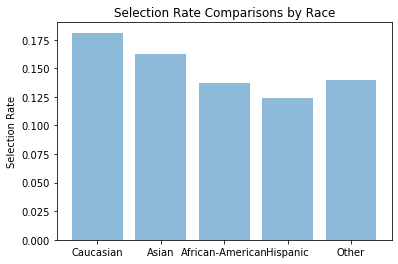

In [27]:
# Run This Cell (1-3 Lines) #
graphSelectionRates(candidatesSelected, candidates_processed, "race")

### Task 6: Iterate!

So, you may be ecstatic or baffled with your results. Either way, the point now is to try and iteratively improve your approach so that your team is satisfied with the model's performance or thinks they can justify their decisions and the model's behavior. Now that you made your first way through, take the time to think about changing your data engineering process, model architecture, selection methods, etc. to try and improve results. Recall that "improving" can mean different things for different folks based on your priorities. For some that will mean enhancing the accuracy of the model on the employees. For others it will be rectifying the disparate outcomes on the candidate dataset. Some will need to narrow their selection rate overall, ohers will need to widen it. 

Your team may not arrive at an approach you are wholly satisfied with - that's totally alright! Sometimes these problems can seem or even be intractable. Nonetheless, along each of these tasks (1-5), unless you're perfectly happy with the results, you should try at least one to two changes per stage and see what effect it has. You'll need to discuss that experimentation in this final task.


### Final Task: Memo Write-up

Alright time to finally put your writing cap back on.  Now that you've come to an approach you're satisfied with (or settled on), the GC"s office wants a ~2 page write-up of your approach, its advantages, disadvantages, threats of statutory liability, and defenses you should lay out the memo in the following manner.

Memo Outline & Additional Questions....

Outline Guide to the Memo

- Describe your team's model, the architecture, selected features, and data steps.
    - What are some advantages or benefical "features" of your overall approach?
    - What are some disadvantages or risks with your approach?
- Data Handling
    - Starting with Data Engineering, describe how your team decided on the features, performance measure, and label generation method that you ended up with.
    - How did you go about making your decisions?
- Model Choice
    - How did your team choose a model? Why did you choose what you did over the other approached we covered?
    - What were the main decision factors (performance? explainability?)? Were there hyper-parameters that you tweaked?
- Performance - State the model's performance on the test set
    - Accuracy, precision, recall.
    - Also the model's fairness (using the metrics you used).
    - What were your measures on your team's first iteration? How did you go about trying to improve it to what it is now?
- For candidate selection
    - How were candidates ultimately selected? How did you choose this selection method?
    - Was there a disparate impact? If so, discuss the validity of a business necessity-type defense given your approach.
- Race Aware Corrections -
    - In your attempt to improve the model performance or rectify some bias/differential validity problem did you enlist any "Race-Aware" Corrections?
    - Are those corrections lawful under the Ricci v. Weber case and the covered case law we reviewed on Affirmative Action Programs?

**Additional Hypothetical Questions:**

1. Suppose manager's assessment score and the average commute time were heavily biased against minorities leaving only average deals closed, left. But suppose again that average deals closed was a highly noisy feature. A number of the recorded values were inaccurate, or altogether missing for the employees. How would you address the situation.
2. In this case, the Supreme Court rejected a “bottom line” defense in which a defendant tried to justify a preliminary screening test with a significant disparate impact by arguing that the selection process ultimately selected protected candidates at a higher rate. Look deeper into the holding and report how your team believes this effects lawyers and engineers trying to develop automated hiring systems.
3. Suppose your model was built such that given the current employee dataset, there was not a clear 4/5s violation in the candidate selection rates but there still existed a ~15 percent disparity between a minority group and the highest performing group.  One suggestion is to seek to gather more data on past employees to have the model train on and improve from, but this can be a costly process both in dollars and time.  How would your team go about trying to decide on a course of action? What context is key?